# Walmart Shopping Trip Classification
### Data Understanding
- **TripType** - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
- **VisitNumber** - an id corresponding to a single trip by a single customer
- **Weekday** - the weekday of the trip
- **Upc** - the UPC number of the product purchased
- **ScanCount** - the number of the given item that was purchased. A negative value indicates a product return.
- **DepartmentDescription** - a high-level description of the item's department
- **FinelineNumber** - a more refined category for each of the products, created by Walmart

### Reference: 
[Kaggle Link](https://www.kaggle.com/competitions/walmart-recruiting-trip-type-classification/overview)


In [32]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings
warnings.filterwarnings(action='ignore')

from zipfile import ZipFile
from sklearn import svm, tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from matplotlib import pyplot as plt
%matplotlib inline


In [33]:
# load and preview training date
df = pd.read_csv('train.csv')
df.head(30)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0
6,26,8,Friday,2.006614e+09,1,PAINT AND ACCESSORIES,1017.0
7,26,8,Friday,7.004803e+09,1,PAINT AND ACCESSORIES,2802.0
8,26,8,Friday,2.238495e+09,1,PAINT AND ACCESSORIES,4501.0
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0


In [34]:
# basic DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [35]:
# get a copy of the original data and edit this copy forward
df_preprocessing = df.copy()

# missing values in original data
print(df_preprocessing.isnull().sum(),'\n')
print(df_preprocessing.isnull().sum()/df_preprocessing.shape[0] * 100, '\n')

# Removing redundency in department description column
print(df_preprocessing.DepartmentDescription.unique(),'\n')
df_preprocessing = df_preprocessing.replace('MENS WEAR','MENSWEAR')

# are upc and FinelineNumber always missing together?
upc_null = df_preprocessing.Upc.isnull()
print(df_preprocessing.FinelineNumber[upc_null].isnull().mean() * 100, 
      '% of UPC and FinelineNumber values are missing together')

# what are the values of dept when upc/FinelineNumber are missing?
print("Department of missing items:", df_preprocessing.DepartmentDescription[upc_null].unique(), '\n')

# when dept is missing, are both upc and FinelineNumber missing?
dept_null = df_preprocessing.DepartmentDescription.isnull()

# only need to test one of upc and FinelineNumber
print(df_preprocessing.FinelineNumber[dept_null].isnull().mean() * 100, 
      '% of Department and UPC/FinelineNumber values are missing together.', '\n')

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64 

TripType                 0.000000
VisitNumber              0.000000
Weekday                  0.000000
Upc                      0.638123
ScanCount                0.000000
DepartmentDescription    0.210338
FinelineNumber           0.638123
dtype: float64 

['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS

In [36]:
# drop NA values
df_preprocessing = df_preprocessing.dropna()

In [37]:
# basic DataFrame info after dropna()
df_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               642925 non-null  int64  
 1   VisitNumber            642925 non-null  int64  
 2   Weekday                642925 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              642925 non-null  int64  
 5   DepartmentDescription  642925 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


### My Note:
Our data set, in its original form, contains 7 fratures and 647,054 observations. The features are as follow:

TripType: Each distinct value represents a unique trip type, i.e., the set of circumstances that underlie the customer's to a Walmart store. Trip Types could include anything from "weekly grocery trip" to "buying bread (or dinner) on the way home from work." The values in this column are integers, and we don't have a key mapping each integer to a trip rationale, so we will have to work with them without knowing what the number actually mean. Although the values are stored as integers, this is a discrete/categorical variable, and it is also our target variable.

VisitNumber: Each distinct value represents a single trip by a Walmart shopper. This is our identidier variable for the dataset we will actually use to train the logistic regression classifier and predict values of TripType. 

Weekday: The day of the week on whic the trip to Walmart was made.

UPC: This feature contains the UPC barcode number that identifies peoducts sold in stores.

ScanCount: The number pf a particular item that customer purchase.

Department Description: Walmart breaks its stores up into a number of departments which are mutually exclusive.

Fineline Number: This is a numeric value representing a "product category".


In [38]:
# makea sample data showing the relationship between Trip Types and Depts
sample = pd.crosstab(index    = df_preprocessing.TripType,
                     columns  = df_preprocessing.DepartmentDescription,
                     rownames = ['Trip Type'],
                     colnames = ['Department Description'],
                     margins  = False)
sample

Department Description,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
Trip Type,,,,,,,,,,,,,,,,,,,,,
3,2,2,20,5,8,24,4,4,9,0,...,0,0,13,0,6,2,16,2,6,3
4,0,1,3,13,0,7,0,0,0,0,...,0,0,9,0,1,0,2,0,2,0
5,1,16,40,66,25,232,7,15,15,9,...,3,1,97,6,40,16,39,0,19,11
6,1,3,5,23,6,23,2,2,1,0,...,4,1,56,0,13,4,9,0,3,1
7,3,11,31,897,5,75,8,15,6,2,...,330,0,3669,4,29,12,30,3,20,11
8,0,6,56,472,36,1112,6,17,16,6,...,2,0,218,3,50,9,31,9,28,8
9,80,186,889,61,223,164,130,101,273,165,...,0,1,70,57,636,177,661,55,573,282
12,0,0,4,16,14,18,1,1,3,2,...,5,1,17,0,13,2,17,2,65,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: xlabel='Trip Type', ylabel='Department Description'>

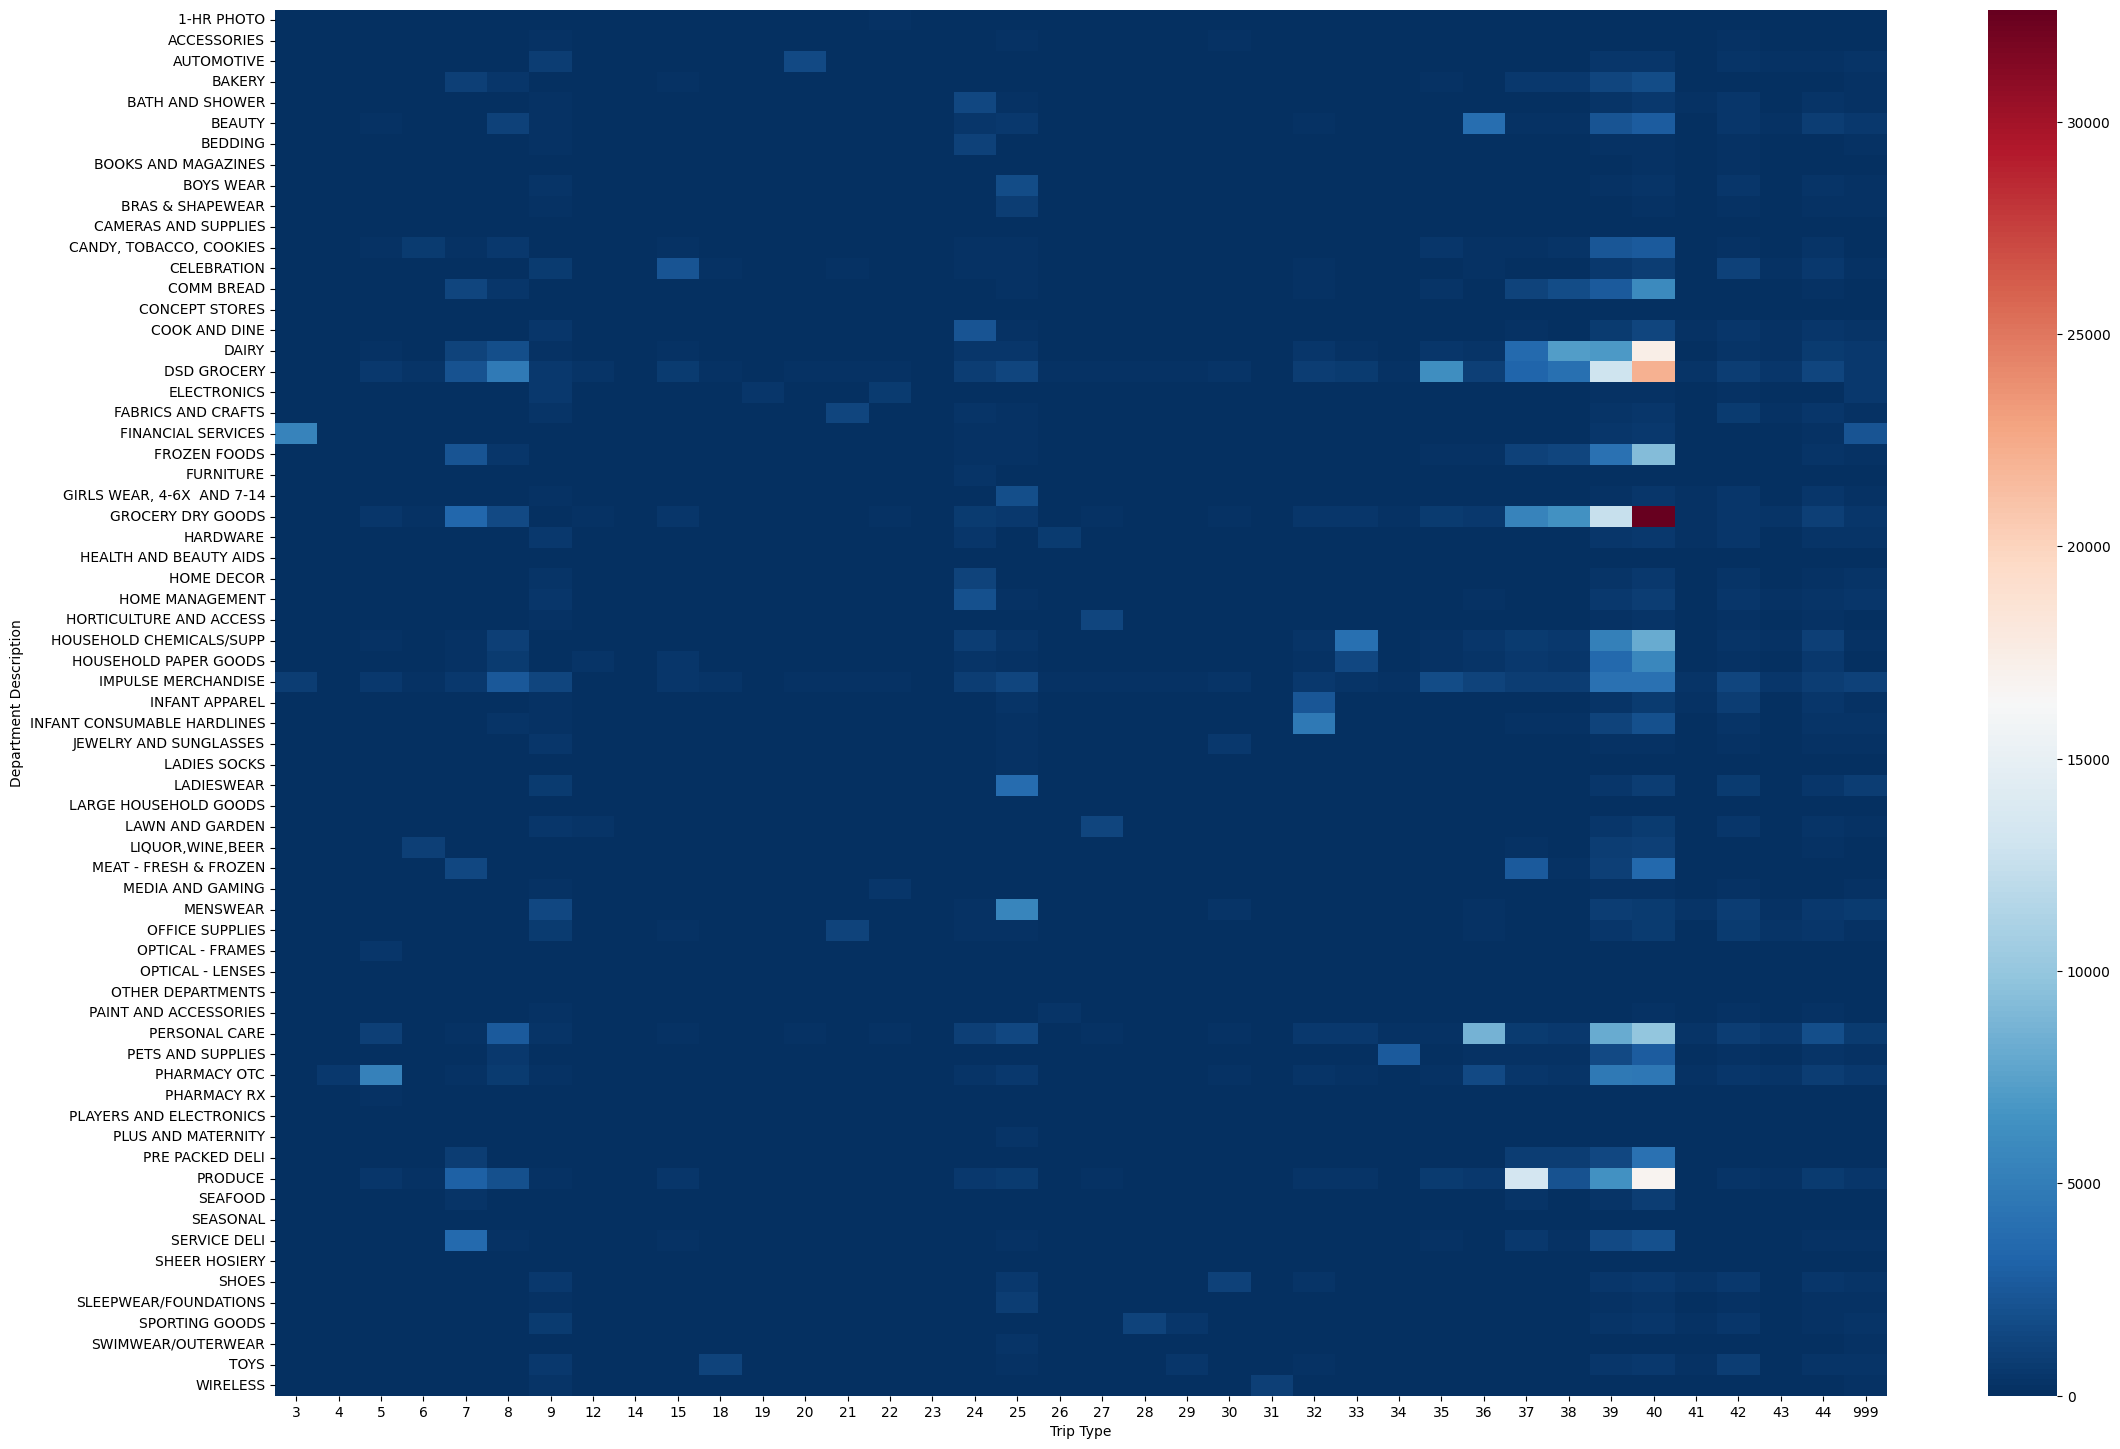

In [39]:
# draw a heatmap to visualize the table above
plt.subplots(figsize = (26,18))
sns.heatmap(data = sample.T, cmap = 'RdBu_r')

### My note: 
Based on the heatmap, there is a serious problem about class imbalance.

## Feature Engineering & Data Preparation

In [40]:
# Feature building by constructing a def with input table called "data"
def data_generator(data):
    # Need more thinking and algorithm here
    # Distinguish Return and NumItems purchased
    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.ScanCount < 0, 'ScanCount'] = 0
    data.loc[data.ScanCount > 0, 'Return'] = 0
    data = data.rename(columns = {'ScanCount' : 'NumItems'})
    
    # Dummy Varible
    dummies = pd.get_dummies(data.DepartmentDescription)

    # Calculation - make dummies presenting number of item bought
    data_dummies = dummies.apply(lambda x: x * data.NumItems)
    
    # Table Concatenation on calculations
    data = pd.concat([data, data_dummies], axis = 1)

    # Groupby / Find baskets
    group = data.groupby('VisitNumber').agg({'TripType': np.max, 
                                             'Weekday' : np.max,
                                 'NumItems': np.sum,
                                 'Return': np.max, 
                                 '1-HR PHOTO' : np.sum,
                                 'ACCESSORIES': np.sum,
                                'AUTOMOTIVE': np.sum,
                                'BAKERY': np.sum, 
                                'BATH AND SHOWER': np.sum, 
                                'BEAUTY': np.sum,
                                'BEDDING': np.sum,
                                'BOOKS AND MAGAZINES': np.sum, 
                                'BOYS WEAR': np.sum, 
                                'BRAS & SHAPEWEAR': np.sum,
                                'CAMERAS AND SUPPLIES': np.sum,
                                'CANDY, TOBACCO, COOKIES': np.sum, 
                                'CELEBRATION': np.sum,
                                'COMM BREAD': np.sum,
                                'CONCEPT STORES': np.sum, 
                                'COOK AND DINE': np.sum, 
                                'DAIRY': np.sum, 
                                'DSD GROCERY' : np.sum,
                                'ELECTRONICS': np.sum, 
                                'FABRICS AND CRAFTS': np.sum, 
                                'FINANCIAL SERVICES': np.sum,
                                'FROZEN FOODS': np.sum, 
                                'FURNITURE': np.sum, 
                                'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
                                'GROCERY DRY GOODS': np.sum, 
                                'HARDWARE': np.sum, 
                                'HEALTH AND BEAUTY AIDS': np.sum, 
                                'HOME DECOR': np.sum,
                                'HOME MANAGEMENT': np.sum, 
                                'HORTICULTURE AND ACCESS': np.sum,
                                'HOUSEHOLD CHEMICALS/SUPP': np.sum, 
                                'HOUSEHOLD PAPER GOODS': np.sum,
                                'IMPULSE MERCHANDISE': np.sum, 
                                'INFANT APPAREL': np.sum, 
                                'INFANT CONSUMABLE HARDLINES': np.sum,
                                'JEWELRY AND SUNGLASSES': np.sum, 
                                'LADIES SOCKS': np.sum, 
                                'LADIESWEAR': np.sum,
                                'LARGE HOUSEHOLD GOODS': np.sum, 
                                'LAWN AND GARDEN': np.sum, 
                                'LIQUOR,WINE,BEER': np.sum,
                                'MEAT - FRESH & FROZEN': np.sum, 
                                'MEDIA AND GAMING': np.sum, 
                                'MENSWEAR': np.sum,
                                'OFFICE SUPPLIES': np.sum, 
                                'OPTICAL - FRAMES': np.sum, 
                                'OPTICAL - LENSES': np.sum,
                                'OTHER DEPARTMENTS': np.sum, 
                                'PAINT AND ACCESSORIES': np.sum, 
                                'PERSONAL CARE': np.sum,
                                'PETS AND SUPPLIES': np.sum, 
                                'PHARMACY OTC': np.sum, 
                                'PHARMACY RX': np.sum,
                                'PLAYERS AND ELECTRONICS': np.sum, 
                                'PLUS AND MATERNITY': np.sum, 
                                'PRE PACKED DELI': np.sum,
                                'PRODUCE': np.sum, 
                                'SEAFOOD': np.sum, 
                                'SEASONAL': np.sum, 
                                'SERVICE DELI': np.sum, 
                                'SHEER HOSIERY': np.sum,
                                'SHOES': np.sum, 
                                'SLEEPWEAR/FOUNDATIONS': np.sum, 
                                'SPORTING GOODS': np.sum,
                                'SWIMWEAR/OUTERWEAR': np.sum,
                                'TOYS': np.sum, 
                                'WIRELESS': np.sum})
    
    return group

In [41]:
df_preprocessing = data_generator(df_preprocessing)
print(df_preprocessing.shape)

(94247, 71)


<AxesSubplot: title={'center': 'Trip Type'}>

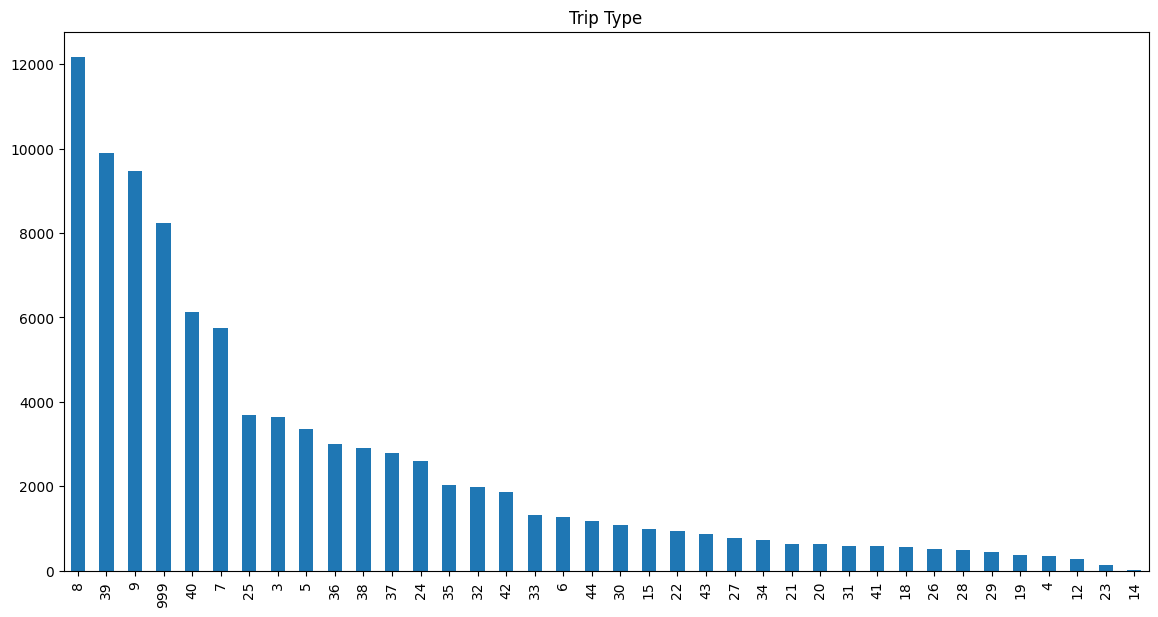

In [42]:
# ploting the bar chart for the trip type
plt.figure(figsize = (14,7))
df_preprocessing.TripType.value_counts().plot(kind = 'bar', title = 'Trip Type')

### My Note:
There is a significant class imbalance in terms of predicting object, TripType. So eliminating extremely popular trip types and unpopular trip types to balance.

In [43]:
# select only the following trip type: 5,25,3,36,38,37,24,35,32
# show data description
df_preprocessing = df_preprocessing[df_preprocessing.TripType.isin([5,25,3,36,38,37,24,35,32])]
df_preprocessing.describe()

,TripType,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,...,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000
mean,24.557519,7.971423,0.052468,0.001383,0.011062,0.020511,0.077473,0.086653,0.237834,0.056002,...,0.015748,0.000192,0.065527,0.005147,0.045477,0.044056,0.018475,0.014865,0.029076,0.002573
std,13.385487,8.526265,0.222973,0.067878,0.152671,0.210452,0.397944,0.811507,1.050052,0.473154,...,0.176557,0.016396,0.357011,0.134264,0.308776,0.383079,0.203687,0.194734,0.258005,0.060353
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,38.000000,313.000000,1.000000,7.000000,7.000000,10.000000,12.000000,69.000000,47.000000,18.000000,...,7.000000,2.000000,8.000000,10.000000,12.000000,18.000000,14.000000,8.000000,10.000000,4.000000


In [44]:
# show the mean of bottom 20 least popular departments
df_preprocessing.mean().sort_values().head(20)

HEALTH AND BEAUTY AIDS     0.000038
CONCEPT STORES             0.000077
OTHER DEPARTMENTS          0.000115
SEASONAL                   0.000192
CAMERAS AND SUPPLIES       0.000576
1-HR PHOTO                 0.001383
PLAYERS AND ELECTRONICS    0.001767
WIRELESS                   0.002573
LARGE HOUSEHOLD GOODS      0.002919
OPTICAL - LENSES           0.003342
SHEER HOSIERY              0.005147
BOOKS AND MAGAZINES        0.006683
PHARMACY RX                0.006799
MEDIA AND GAMING           0.007029
ELECTRONICS                0.007644
PAINT AND ACCESSORIES      0.008527
HORTICULTURE AND ACCESS    0.010716
ACCESSORIES                0.011062
LADIES SOCKS               0.012022
PLUS AND MATERNITY         0.012291
dtype: float64

<AxesSubplot: title={'center': 'Trip Type'}>

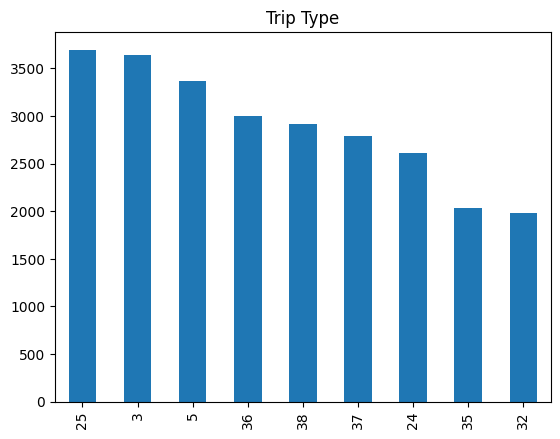

In [45]:
# ploting the bar chart for the trip type
df_preprocessing.TripType.value_counts().plot(kind = 'bar', title = 'Trip Type')

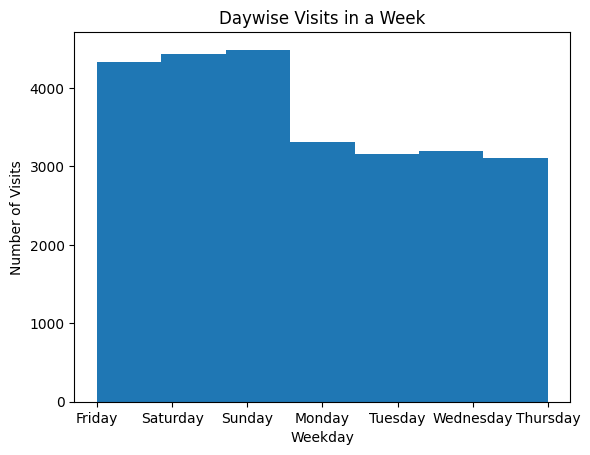

In [46]:
# ploting historgram for daywise visits
plt.hist(df_preprocessing.Weekday, 7)
plt.xlabel('Weekday')
plt.ylabel('Number of Visits')
plt.title('Daywise Visits in a Week')
plt.show()

In [47]:
# use label Encoder to convert weekdays to computer readable values
labelencoder = LabelEncoder()
df_preprocessing.Weekday = labelencoder.fit_transform(df_preprocessing.Weekday)

In [48]:
df.Weekday.map({'Monday' : 1,
                'Tuesday': 2,
                'Wednesday': 3,
                'Tuesday' : 4,
                'Friday':5,
                'Saturday':6,
                'Sunday':7})

0         5.0
1         5.0
2         5.0
3         5.0
4         5.0
         ... 
647049    7.0
647050    7.0
647051    7.0
647052    7.0
647053    7.0
Name: Weekday, Length: 647054, dtype: float64

## Train & Test Split

In [49]:
# Make a new copy pf the data
train_data = df_preprocessing.copy()

In [50]:
x = train_data.drop(['TripType',
                     'HEALTH AND BEAUTY AIDS',
                     'CONCEPT STORES',
                     'OTHER DEPARTMENTS',
                     'SEASONAL',
                     'CAMERAS AND SUPPLIES',
                     '1-HR PHOTO'], axis = 'columns').values


In [51]:
# Drop TripType (for y) and the least popular 6 depts. leaving the rest for X
# splitting data into training, validation and test data
X_train, X_test, y_train, y_test =  train_test_split(x,
                                                     train_data.TripType.values,
                                                     train_size = 0.8,
                                                     random_state = 999)

In [52]:
# show data shape
print(X_train.shape, '\n')
print(X_test.shape, '\n')
print(y_train.shape, '\n')
print(y_train.shape, '\n')

(20828, 64) 

(5207, 64) 

(20828,) 

(20828,) 



## Modeling 
### Supervised Learning - Logical Regression



In [54]:
%%time

lr = LogisticRegression(C = 1, penalty= 'l1', tol = 1e-4 ,solver = 'liblinear')
lr_fit = lr.fit(X_train, y_train)
lr_prediction = lr_fit.predict(X_test)

CPU times: user 4.58 s, sys: 22.8 ms, total: 4.6 s
Wall time: 4.62 s


array([35, 35, 36, ..., 38, 24, 35])

### Accuracy of Logistic Regression

In [56]:
print('The accuracy of Logistic Regression is ','{:.2%}'.format(accuracy_score(y_test, lr_prediction)))

The accuracy of Logistic Regression is  89.38%


### Log Loss Logistic Regression
**Loss function(损失函数)** 用来估量模型的预测值f(x)与真实值Y的不一致程度。它是一个非负实值函数，通常用L(Y,f(x))来表示，**损失函数越小，模型的可靠性就越好**。损失函数是经验风险函数的核心部分，也是结构风险函数最要组成部分。模型的结构分析函数包括了经验风险项和正则项。
- 对数损失函数
- 平均损失函数

In [58]:
print('The log loss of Logistic Regression prediction is ','{:.4}'.format(log_loss(y_test, lr.predict_proba(X_test))))

The log loss of Logistic Regression prediction is  0.3868


### Confusion Matrix on Logistic Regression

In [61]:
pd.crosstab(index = y_test, columns = lr_prediction, rownames=['Actual'], colnames=['prediction'], margins= True)

prediction,3,5,24,25,32,35,36,37,38,All
Actual,,,,,,,,,,
3,725,0,1,2,1,0,0,1,0,730
5,1,605,5,1,1,4,23,6,7,653
24,3,11,423,11,2,6,13,7,9,485
25,3,8,2,729,2,3,8,5,5,765
32,2,3,3,7,342,9,10,2,10,388
35,0,8,4,4,1,321,6,17,32,393
36,3,36,13,15,6,6,526,6,9,620
37,1,6,12,4,2,8,2,491,31,557
38,1,10,11,4,3,41,15,39,492,616


### Classification Report on Logistic Regression

In [62]:
print(classification_report(y_test, lr_prediction))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.88      0.93      0.90       653
          24       0.89      0.87      0.88       485
          25       0.94      0.95      0.95       765
          32       0.95      0.88      0.91       388
          35       0.81      0.82      0.81       393
          36       0.87      0.85      0.86       620
          37       0.86      0.88      0.87       557
          38       0.83      0.80      0.81       616

    accuracy                           0.89      5207
   macro avg       0.89      0.89      0.89      5207
weighted avg       0.89      0.89      0.89      5207



### Logistic Regression Main Parameter
- penalty: str , 'l1', 'l2', default: 'l2'
- tol: float , default: 1e-4 算法停止边界，越大停止越快
- C: float, default: 1.0 正则化强度的逆， 必须是正的浮点数。 如svm， 越小的值代表越大的正则化。
- solver: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default: 'liblinear', 用于问题的优化。

### Streamlining Workingflows with Pipelines

In [65]:
%%time

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components= 64)),
                    ('clf', LogisticRegression(C            = 1, 
                                               penalty      = 'l1', 
                                               tol          = 1e-4, 
                                               solver       = 'liblinear', 
                                               random_state = 0))])
pipe_lr.fit(X_train,y_train)
print('Test Accuracy: %.2f' % pipe_lr.score(X_test,y_test))

Test Accuracy: 0.89
CPU times: user 8.72 s, sys: 303 ms, total: 9.02 s
Wall time: 8.4 s


### Debugging Algorithm
**Learning Curve**

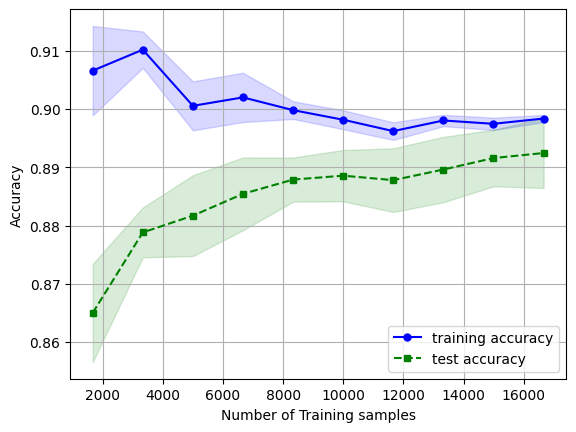

In [68]:
# produce train_sizes, train_scores, and test_scores using learning_curve()
train_sizes, train_scores,test_scores = learning_curve(estimator= pipe_lr, 
                                                                     X = X_train,
                                                                     y = y_train,
                                                                     train_sizes = np.linspace(0.1,1,10),
                                                                     cv = 5,
                                                                     n_jobs= -1 )

# use np.mean() and np.std() to get the mean and standard deviation for train and test scores
train_mean = np.mean(train_scores,axis = 1)
train_std = np.std(train_scores,axis = 1)
test_mean = np.mean(test_scores, axis =1)
test_std = np. std(test_scores, axis =1)

# use.plot and .fill_between() to plot the curve
plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o' , markersize = 5, label = 'training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean, color = 'green',linestyle = '--', marker = 's' , markersize = 5, label = 'test accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean - test_std, alpha = 0.15, color = 'green')
plt.grid()
plt.xlabel('Number of Training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()


**Validation Curve** 

In [ ]:
# use validation_curve() to get train_scores and test_scores

# use np.mean() and np.std() to get the mean and standard deviation for train and test scores

# 